In [1]:
import os
import cv2
import scipy
import helper
import warnings
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from distutils.version import LooseVersion

In [2]:
L2_REG = 1e-6
STDEV = 1e-3
KEEP_PROB = 0.75
LEARNING_RATE = 1e-4
EPOCHS = 100
BATCH_SIZE = 16
IMAGE_SHAPE = (156, 512)
NUM_CLASSES = 2

DATA_DIR = './data/'
RUNS_DIR = './data/saved_runs/'
VGG_DIR = './data/saved_models/vgg/'
MODEL_DIR = './data/saved_models/trained_model/road.ckpt'

In [3]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.

    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    # Loads model and weights
    tf.saved_model.loader.load(sess, ['vgg16'], vgg_path)
    graph = tf.get_default_graph()
    input_image = graph.get_tensor_by_name('image_input:0')
    keep_prob = graph.get_tensor_by_name('keep_prob:0')
    vgg_layer3_out = graph.get_tensor_by_name('layer3_out:0')
    vgg_layer4_out = graph.get_tensor_by_name('layer4_out:0')
    vgg_layer7_out = graph.get_tensor_by_name('layer7_out:0')

    return input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out

In [4]:
def conv_1x1(layer, layer_name):
    return tf.layers.conv2d(inputs=layer, 
                            filters=NUM_CLASSES, 
                            kernel_size=(1, 1), 
                            padding='same',
                            kernel_initializer=tf.truncated_normal_initializer(stddev=STDEV),
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_REG), 
                            name=layer_name)

In [5]:
def upsample(layer, k, s, layer_name):
  """ Return the output of transpose convolution given kernel_size k and strides s """
  return tf.layers.conv2d_transpose(inputs=layer,
                                    filters=NUM_CLASSES, 
                                    kernel_size=(k, k), 
                                    strides=(s, s),
                                    padding='same',
                                    kernel_initializer=tf.truncated_normal_initializer(stddev=STDEV),
                                    kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_REG),
                                    name=layer_name)

In [6]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes= NUM_CLASSES):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    # layer 7 1x1 convolution
    layer7_1x1 = conv_1x1(layer=vgg_layer7_out,layer_name='layer7_1x1')

    # upsample 1
    output_1 = upsample(layer=layer7_1x1, k=4, s=2, layer_name='upsample_1') 

    # layer 4 1x1 convolution
    layer4_1x1 = conv_1x1(layer=vgg_layer4_out,layer_name='layer4_1x1')

    # Skip layer
    skip_layer_1 = tf.add(output_1, layer4_1x1, name='skip_layer_1')

    # upsample 2
    output_2 = upsample(layer=skip_layer_1, k=4, s=2, layer_name='output_2')

    # layer 3 1x1 convolution
    layer3_1x1 = conv_1x1(layer=vgg_layer3_out,layer_name='layer3_1x1')

    # Skip layer
    skip_layer_2 = tf.add(output_2, layer3_1x1, name='skip_layer_2')

    # upsample 3
    last_layer = upsample(layer=skip_layer_2, k=16, s=8, layer_name='last_layer')

    return last_layer

In [7]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes=NUM_CLASSES):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    # Convert 4D output tensor from last layer to 2D logits
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    correct_label = tf.reshape(correct_label, (-1, num_classes))

    # Standard cross entropy for binary classification using logtis from above
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=correct_label)
    cross_entropy_loss = tf.reduce_mean(cross_entropy)
    
    #  When adding l2-regularization, setting a regularizer in the arguments of 
    # the tf.layers is not enough. Regularization loss terms must be manually 
    # added to your loss function. otherwise regularization is not implemented.
    regularization_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    cross_entropy_loss = tf.add(cross_entropy_loss, sum(regularization_losses))

    # Adam optimizer with custom learning rate minimizing the cross entropy loss function
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(cross_entropy_loss)

    return logits, train_op, cross_entropy_loss

In [8]:
def train_nn(sess, epochs, batch_size, total_batches, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """

    print('Starting Training, Number of Epochs {}'.format(epochs))
    # Initialize session variables
    sess.run(tf.global_variables_initializer())

    for epoch in range(1, epochs+1):
        total_loss = 0
        progress_bar = tqdm(range(total_batches))
        for i in progress_bar:
            # Training
            image, label = next(get_batches_fn(batch_size))
            _, loss = sess.run([train_op, cross_entropy_loss],
                               feed_dict={input_image: image, correct_label: label,
                                          keep_prob: KEEP_PROB, learning_rate: LEARNING_RATE})
            total_loss += loss
            progress_bar.set_description('Epoch: {}/{} | Loss: {:4.4f}'.format(epoch, epochs, total_loss))

In [9]:
def run():
    image_shape = (160, 576)
    
    helper.maybe_download_pretrained_vgg(DATA_DIR)

    tf.reset_default_graph()
    with tf.Session() as sess:
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function(data_folder='./data/data_road/training/', image_shape=image_shape)

        # Build NN using load_vgg, layers, and optimize function
        input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg(sess, VGG_DIR)

        last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out)

        correct_label = tf.placeholder(tf.float32, [None, None, None, NUM_CLASSES], name='correct_label')
        learning_rate = tf.placeholder(tf.float32, name='learning_rate')

        logits, train_op, cross_entropy_loss = optimize(last_layer, correct_label, learning_rate)

        # Train NN using the train_nn function
        print('Model Built')
        total_batches = len(os.listdir('./data/data_road/training/image_2/'))//BATCH_SIZE
        train_nn(sess, EPOCHS, BATCH_SIZE, total_batches, get_batches_fn, train_op, cross_entropy_loss, input_image,
                 correct_label, keep_prob, learning_rate)
        
        # Save Model
        saver = tf.train.Saver()
        save_path = saver.save(sess, MODEL_DIR)

        # TODO: Save inference data using helper.save_inference_samples
#         helper.save_inference_samples(RUNS_DIR, DATA_DIR, sess, image_shape, logits, keep_prob, input_image)

        # OPTIONAL: Apply the trained model to a video

In [67]:
def predict_single_image(image_dir):
    image_shape = (160, 576)
    
    # Read image from directory, convert it from BGR to RGB, resize it to image_shape
    image = cv2.resize(cv2.cvtColor(cv2.imread(image_dir), cv2.COLOR_BGR2RGB), image_shape[::-1])
    
    # Reset default graph and create session to ensure there are no errors
    tf.reset_default_graph()
    sess = tf.Session()
    
    # Create stuff
    input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg(sess, VGG_DIR)
    last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out)
    logits = tf.reshape(last_layer, (-1, NUM_CLASSES))
    
    # Load previously trained model
    saver = tf.train.Saver()
    saver.restore(sess, MODEL_DIR)
    
    # To visualize results
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25,15))
    
    # Run image through graph and perform softmax activation on logits
    im_softmax = sess.run([tf.nn.softmax(logits)], {keep_prob: 1.0, input_image: [image]})
    
    # Softmax currently has shape (batch, imshape[0]*imshape[1], numclasses) or (1, 92160, 2)
    # We reshape it into the same as the image in order to paste it
    im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
    ax1.imshow(im_softmax)
    ax1.set_title('Softmax activations ranging from 0 to 1')
    
    # Any value greater then 0.5 returns as True (1) and then is multiplied by an array of RGBA where 
    # A is the transperancy. Chosen color of green for the mask
    segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
    mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
    ax2.imshow(mask)
    ax2.set_title('Mask that was multiplied by [0,255,0] to make color green')
    
    #RGB and with transparency mask
    mask = scipy.misc.toimage(mask, mode="RGBA") 
    street_im = scipy.misc.toimage(image) # Convert image numpy array to PIL image in order to paste mask
    ax3.imshow(street_im)
    ax3.set_title('Original Image')
    
    street_im.paste(mask, box=None, mask=mask)
    ax4.imshow(street_im)
    ax4.set_title('Original image with mask pasted onto it')

In [68]:
# run()
# predict_images()

INFO:tensorflow:Restoring parameters from b'./data/saved_models/vgg/variables/variables'
INFO:tensorflow:Restoring parameters from ./data/saved_models/trained_model/road.ckpt


/home/pablo/miniconda3/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
/home/pablo/miniconda3/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


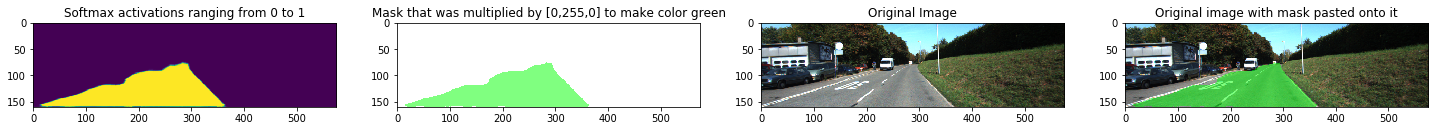

In [69]:
image_dir = 'data/images/testing/image_2/um_000016.png'
predict_single_image(image_dir)